In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
import math
import torchvision.models as models
from PIL import Image
from deepfool.deepfool import *
import os
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchvision import transforms, models ,datasets
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
NUM_CLASSES = 100
MAX_ITER = 100
OVERSHOOT = 0.02

In [3]:
def clip_tensor(A, minv, maxv):
    return torch.clamp(A, minv, maxv)


def diff(original_images, perturbed_images):
    difference_images = []
    for orig, pert in zip(original_images, perturbed_images):
        orig_tensor = (
            transforms.ToTensor()(orig) if isinstance(orig, Image.Image) else orig
        )
        pert_tensor = (
            transforms.ToTensor()(pert) if isinstance(pert, Image.Image) else pert
        )
        diff_tensor = torch.abs(orig_tensor - pert_tensor)
        diff_image = transforms.ToPILImage()(diff_tensor)
        difference_images.append(diff_image)
    return difference_images


def plot_diff(original_images, perturbed_images):
    assert (
        len(original_images) == len(perturbed_images)
    ), f"Number of original ({len(original_images)}) and perturbed ({len(perturbed_images)}) images must be the same"

    difference_images = diff(original_images, perturbed_images)
    fig_diff, ax_diff = plt.subplots(1, len(difference_images), figsize=(20, 5))
    for col in range(len(difference_images)):
        diff_im = transforms.ToTensor()(difference_images[col])
        diff_gray = torch.mean(diff_im, dim=0)
        im = ax_diff[col].imshow(diff_gray, cmap="gray")
        ax_diff[col].set_title(f"Difference {col+1}")
        ax_diff[col].axis("off")
        fig_diff.colorbar(im, ax=ax_diff[col], orientation="vertical")
    plt.tight_layout()
    plt.show()


# Checking normalise/denormalise bug
Float op error

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor image using mean and std.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization
    return tensor

# Function to clip tensor values to valid range [0, 1]
def clamp(tensor):
    return tensor.clamp(0, 1)

custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),  # Normalize image
    transforms.Lambda(lambda x: denormalize(x, mean, std)),  # Denormalize image
    transforms.Lambda(clamp),  # Clip the values to ensure valid image range
    transforms.ToPILImage(),  # Convert tensor back to PIL image
    transforms.ToTensor(),  # Convert back to tensor for further processing
])


clip = lambda x: clip_tensor(x, 0, 255)

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Normalize(
        mean=[0, 0, 0], std=[1 / s for s in std]
    ),  # Reverse normalization
    transforms.Normalize(
        mean=[-m for m in mean], std=[1, 1, 1]
    ),  # Subtract mean
    transforms.Lambda(clip),  # Clip the values to ensure valid image range
    transforms.ToPILImage(),  # Convert tensor back to PIL image
    transforms.ToTensor(),  # Convert back to tensor
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])


train_dataset = datasets.ImageFolder(
    "./dataset/imagenette2/train",
    train_transform
)

custom_dataset = datasets.ImageFolder(
    "./dataset/imagenette2/train",
    custom_transform
)

test_dataset =datasets.ImageFolder(
    "./dataset/imagenette2/train",
    test_transform
)

train_loader = DataLoader(train_dataset, shuffle=False, batch_size=1)
custom_loader = DataLoader(custom_dataset, shuffle=False, batch_size=1)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1)

error = 0
for i in range(200):
    custom_image = custom_loader.dataset[i][0]
    test_image = test_loader.dataset[i][0]
    # plot_diff(custom_image, test_image)
    diff_tensor = diff([custom_image], [test_image])[0]
    diff_tensor = transforms.ToTensor()(diff_tensor)
    # ! error threshold is 0.035/0.004
    if torch.any(diff_tensor > 0.004):
        error += 1
        print(f"{error} errors in {i} images", end="\r")
print(f"{error} errors in {len(custom_loader)} images")

0 errors in 9469 images


# Perturbation comparaison normalised or denormalised
Float op error

In [5]:
def make_examples(func, xargs):
    # Load pretrained ResNet-34 model
    net = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

    # Switch to evaluation mode
    net.eval()

    original_images = []
    original_labels = []
    perturbed_images = []
    perturbed_labels = []
    max_pixel_values = []

    for i in range(1, 7):
        # Load image
        im_orig = Image.open(f"data/demo_deepfool/test_img{i}.jpg")

        # Mean and std used for normalization (ImageNet stats)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        original_images.append(
            transforms.Compose(
                [
                    transforms.Resize(256),  # Updated from transforms.Scale
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ]
            )(im_orig)
        )

        # Preprocessing the image: resize, crop, convert to tensor, and normalize
        im = transforms.Compose(
            [
                transforms.Resize(256),  # Updated from transforms.Scale
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std),
            ]
        )(im_orig).cpu()  # Ensure the tensor is on the CPU

        # Run the provided function (e.g., DeepFool attack)
        r, loop_i, label_orig, label_pert, pert_image = func(im, net, **xargs)

        # Load class labels from file
        labels = (
            open(os.path.join("data/demo_deepfool/synset_words.txt"), "r")
            .read()
            .split("\n")
        )

        # Get original and perturbed class labels
        str_label_orig = labels[int(label_orig)].split(",")[0]  # Changed np.int to int
        str_label_pert = labels[int(label_pert)].split(",")[0]

        original_labels.append(str_label_orig.split()[1:])
        perturbed_labels.append(str_label_pert.split()[1:])

        # Function to clip tensor values between minv and maxv
        def clip_tensor(A, minv, maxv):
            A = torch.clamp(A, minv, maxv)  # Use torch.clamp for cleaner implementation
            return A

        # Clipping function for images (0-255 range)
        clip = lambda x: clip_tensor(x, 0, 255)

        # Inverse transformation to convert perturbed image back to PIL format
        tf = transforms.Compose(
            [
                transforms.Normalize(
                    mean=[0, 0, 0], std=[1 / s for s in std]
                ),  # Reverse normalization
                transforms.Normalize(
                    mean=[-m for m in mean], std=[1, 1, 1]
                ),  # Subtract mean
                transforms.Lambda(clip),  # Clip the values to ensure valid image range
                transforms.ToPILImage(),  # Convert tensor back to PIL image
                transforms.CenterCrop(224),  # Center crop to 224x224
                transforms.ToTensor(),  # Convert back to tensor
            ]
        )

        pert_image = pert_image.view(pert_image.size()[-3:]).type(torch.FloatTensor)
        perturbed_images.append(tf(pert_image))
    return (
        original_images,
        original_labels,
        perturbed_images,
        perturbed_labels,
        max_pixel_values,
    )


In [6]:
def plot_comparaison(
    original_images, perturbed_images, original_labels, perturbed_labels
):
    assert (
        len(original_images)
        == len(perturbed_images)
        == len(original_labels)
        == len(perturbed_labels)
    ), f"Lengths are not equal: original_images={len(original_images)}, perturbed_images={len(perturbed_images)}, original_labels={len(original_labels)}, perturbed_labels={len(perturbed_labels)}"

    fig, ax = plt.subplots(2, len(original_images), figsize=(18, 7))
    for col in range(len(original_images)):
        ax[0][col].imshow(transforms.ToPILImage()(original_images[col]))
        ax[0][col].set_title(f"Original: {original_labels[col]}", fontsize=10)
        ax[0][col].axis("off")
        
        ax[1][col].imshow(transforms.ToPILImage()(perturbed_images[col]))
        ax[1][col].set_title(f"Perturbed: {perturbed_labels[col]}", fontsize=10)
        ax[1][col].axis("off")
    
    fig.suptitle("DeepFool Attack on ResNet34", fontsize=16)
    plt.subplots_adjust(top=0.85, hspace=0.3)
    plt.tight_layout()
    plt.show()



In [7]:
def make_examples_norm(func, xargs):
    # Load pretrained ResNet-34 model
    net = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

    # Switch to evaluation mode
    net.eval()

    original_images = []
    original_labels = []
    perturbed_images = []
    perturbed_labels = []
    max_pixel_values = []

    for i in range(1, 7):
        # Load image
        im_orig = Image.open(f"data/demo_deepfool/test_img{i}.jpg")

        # Mean and std used for normalization (ImageNet stats)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        original_images.append(
            transforms.Compose(
                [
                    transforms.Resize(256),  # Updated from transforms.Scale
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mean, std=std),
                ]
            )(im_orig)
        )

        # Preprocessing the image: resize, crop, convert to tensor, and normalize
        im = transforms.Compose(
            [
                transforms.Resize(256),  # Updated from transforms.Scale
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std),
            ]
        )(im_orig).cpu()  # Ensure the tensor is on the CPU

        # Run the provided function (e.g., DeepFool attack)
        r, loop_i, label_orig, label_pert, pert_image = func(im, net, **xargs)

        # Load class labels from file
        labels = (
            open(os.path.join("data/demo_deepfool/synset_words.txt"), "r")
            .read()
            .split("\n")
        )

        # Get original and perturbed class labels
        str_label_orig = labels[int(label_orig)].split(",")[0]  # Changed np.int to int
        str_label_pert = labels[int(label_pert)].split(",")[0]

        original_labels.append(str_label_orig.split()[1:])
        perturbed_labels.append(str_label_pert.split()[1:])

        pert_image = pert_image.view(pert_image.size()[-3:]).type(torch.FloatTensor)
        perturbed_images.append(pert_image)

    return (
        original_images,
        original_labels,
        perturbed_images,
        perturbed_labels,
        max_pixel_values,
    )


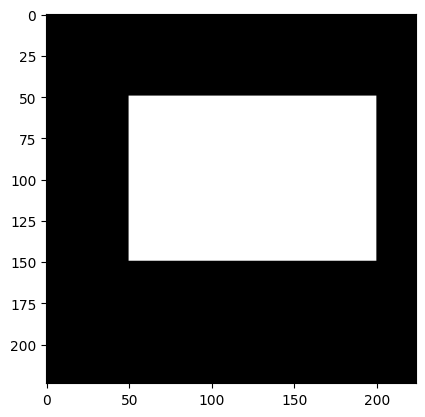

In [8]:
region_mask = np.zeros((224, 224), dtype=np.int32)
region_mask[50:150, 50:200] = 1

plt.imshow((region_mask))
plt.imshow(region_mask, cmap="gray")
plt.show()

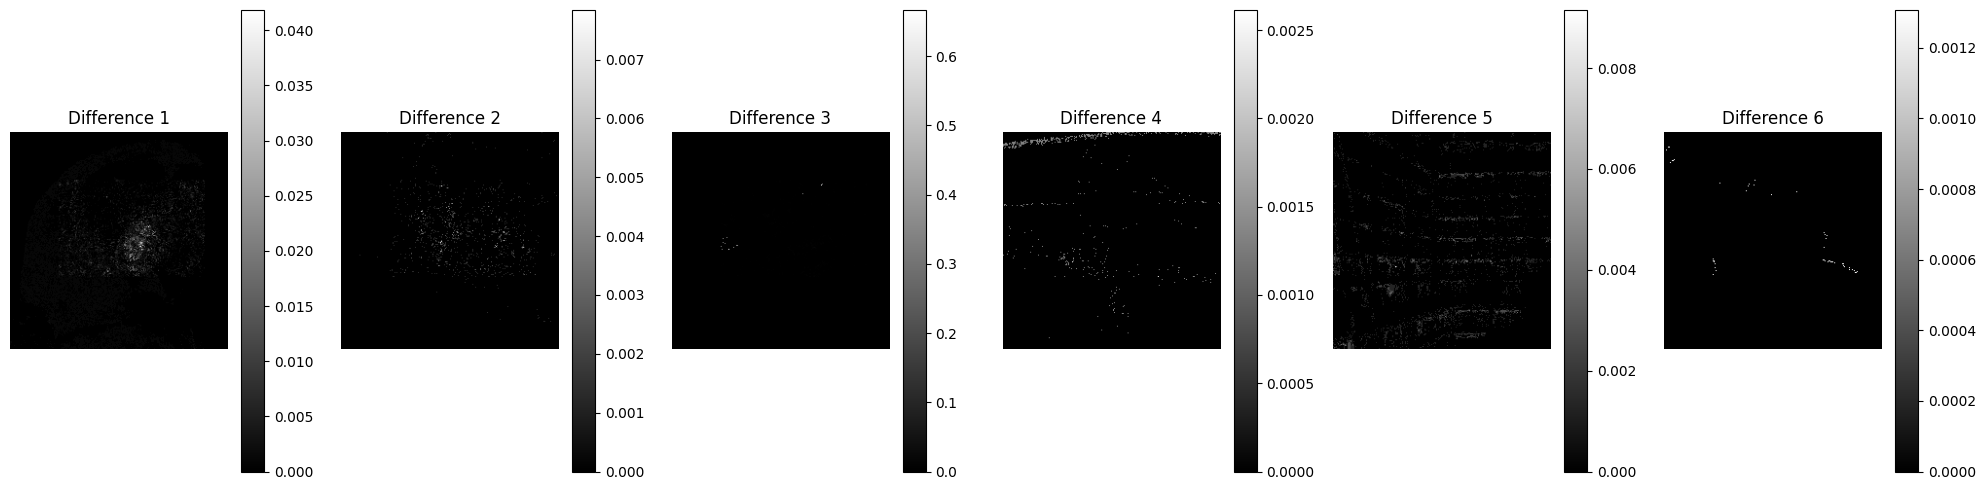

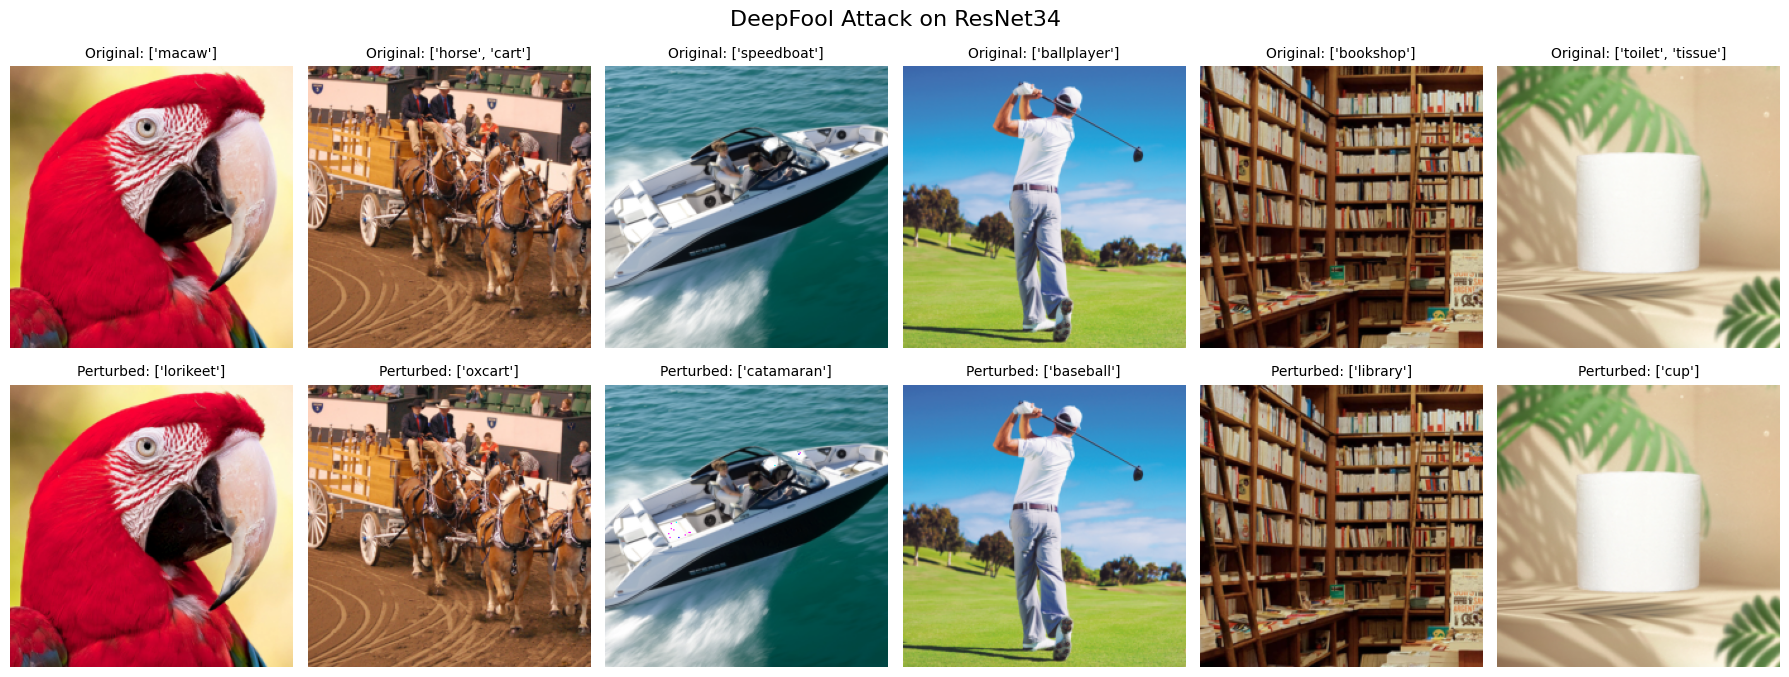

In [9]:
local_deepfool_args = {
    "num_classes": NUM_CLASSES,  # Number of classes
    "overshoot": OVERSHOOT,  # Maximum perturbation allowed
    "max_iter": MAX_ITER,  # Maximum number of iterations
    "region_mask": region_mask,  # Region mask for the image
    "verbose": False,  # Verbosity flag
}

(
    original_images,
    original_labels,
    perturbed_images,
    perturbed_labels,
    max_pixel_values,
) = make_examples(local_deepfool, local_deepfool_args)

plot_diff(original_images, perturbed_images)

plot_comparaison(original_images, perturbed_images, original_labels, perturbed_labels)

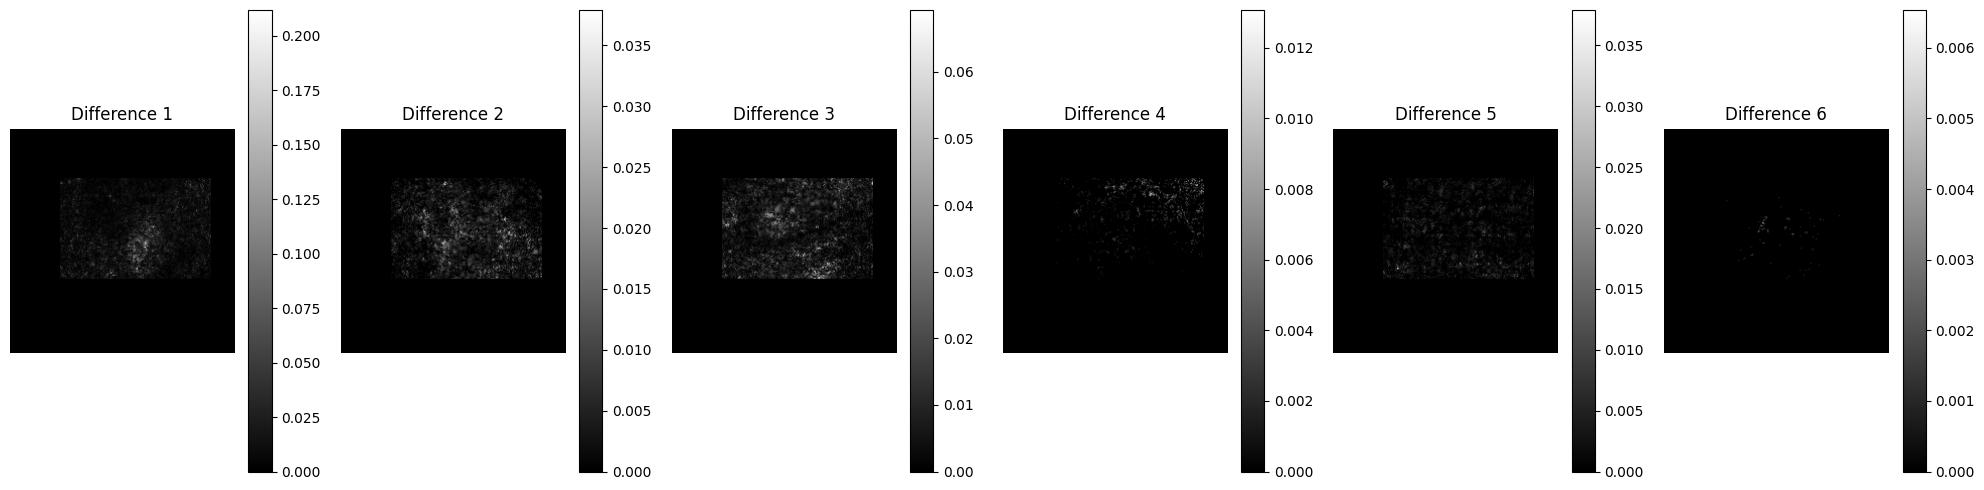

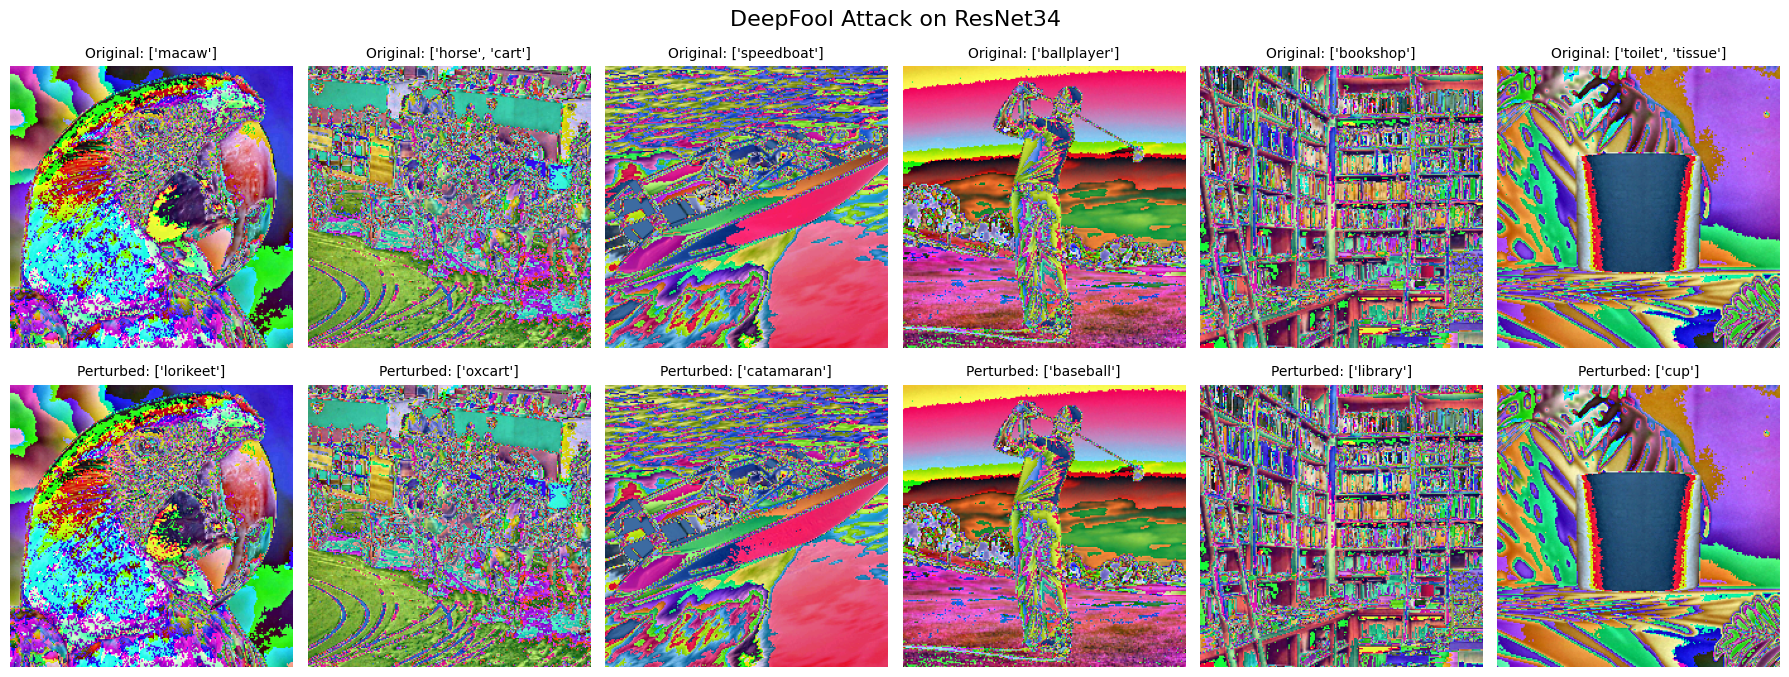

In [10]:
local_deepfool_args = {
    "num_classes": NUM_CLASSES,  # Number of classes
    "overshoot": OVERSHOOT,  # Maximum perturbation allowed
    "max_iter": MAX_ITER,  # Maximum number of iterations
    "region_mask": region_mask,  # Region mask for the image
    "verbose": False,  # Verbosity flag
}

(
    original_images,
    original_labels,
    perturbed_images,
    perturbed_labels,
    max_pixel_values,
) = make_examples_norm(local_deepfool, local_deepfool_args)

plot_diff(original_images, perturbed_images)
plot_comparaison(original_images, perturbed_images, original_labels, perturbed_labels)